Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.lstm import create_data

2024-04-14 16:59:00.292549: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 16:59:00.320319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 16:59:00.320346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 16:59:00.321002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 16:59:00.326442: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases_30_days_ago"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1390, 2)

In [4]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [6]:
X_test[0]

array([[-1.04511465, -0.5936193 ],
       [-0.74824536, -0.5918412 ],
       [-1.02770233, -0.59544102],
       [-1.0603773 , -0.36244814],
       [-1.06123717, -0.50723173],
       [-1.05801267, -0.59883536],
       [-1.05930247, -0.59319458],
       [-1.04575955, -0.59752561],
       [-0.86669212, -0.60153867],
       [-1.02899213, -0.6033558 ],
       [-1.06403174, -0.46704486],
       [-1.06252697, -0.49895995],
       [-1.06360181, -0.60285072],
       [-1.06403174, -0.59722486],
       [-1.03802074, -0.60246732],
       [-0.83810152, -0.60430511],
       [-1.03286154, -0.60580197],
       [-1.0610222 , -0.50292136],
       [-1.06489161, -0.52731425],
       [-1.06532154, -0.59237153],
       [-1.06876101, -0.60057788],
       [-1.05693783, -0.59859086],
       [-0.89979702, -0.60724029],
       [-1.04210511, -0.62263938],
       [-1.0610222 , -0.53794037],
       [-1.06682631, -0.51709334],
       [-1.06854604, -0.63112696],
       [-1.06768618, -0.60038733],
       [-1.05564803,

In [6]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200


14/14 [==============================] - 6s 125ms/step - loss: 0.6941 - root_mean_squared_error: 0.8331 - val_loss: 0.4183 - val_root_mean_squared_error: 0.6468
Epoch 2/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4731 - root_mean_squared_error: 0.6878 - val_loss: 0.2401 - val_root_mean_squared_error: 0.4900
Epoch 3/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4172 - root_mean_squared_error: 0.6459 - val_loss: 0.1607 - val_root_mean_squared_error: 0.4009
Epoch 4/200
14/14 [==============================] - 1s 39ms/step - loss: 0.3948 - root_mean_squared_error: 0.6283 - val_loss: 0.1243 - val_root_mean_squared_error: 0.3526
Epoch 5/200
14/14 [==============================] - 1s 49ms/step - loss: 0.3938 - root_mean_squared_error: 0.6275 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3386
Epoch 6/200
14/14 [==============================] - 1s 48ms/step - loss: 0.3901 - root_mean_squared_error: 0.6246 - val_loss: 0.1194 - val_root_mean_s

In [8]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

5/5 [==============================] - 0s 9ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881
test loss, test acc: [0.083  0.2881]


In [9]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [10]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr


Epoch 1: val_loss improved from inf to 0.12144, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.12144 to 0.09584, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.09584

Epoch 4: val_loss did not improve from 0.09584

Epoch 5: val_loss did not improve from 0.09584

Epoch 6: val_loss did not improve from 0.09584

Epoch 7: val_loss improved from 0.09584 to 0.09250, saving model to best_model.h5

Epoch 8: val_loss improved from 0.09250 to 0.09190, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.09190

Epoch 10: val_loss did not improve from 0.09190

Epoch 11: val_loss did not improve from 0.09190

Epoch 12: val_loss did not improve from 0.09190

Epoch 13: val_loss did not improve from 0.09190
Epoch 13: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.20156750082969666, 0.4489626884460449] and test accuracy: [0.03616929054260254, 0.19018225371837616]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved fr

In [11]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
16,True,True,False,256,28,0.2,"[0.20449614524841309, 0.45221251249313354]","[0.004482671152800322, 0.06695275008678436]"
70,False,False,False,256,28,0.2,"[0.20419208705425262, 0.4518761932849884]","[0.0049819136038422585, 0.07058267295360565]"
10,True,True,False,64,28,0.2,"[0.25903621315956116, 0.5089560151100159]","[0.005041447933763266, 0.07100315392017365]"
1,True,True,True,64,28,0.2,"[0.27037620544433594, 0.5199770927429199]","[0.006054284051060677, 0.07780928164720535]"
25,True,False,True,256,28,0.2,"[0.21320879459381104, 0.46174538135528564]","[0.00617319718003273, 0.078569695353508]"
...,...,...,...,...,...,...,...,...
11,True,True,False,64,365,0.2,"[0.29506975412368774, 0.5432032346725464]","[0.14343494176864624, 0.37872806191444397]"
5,True,True,True,128,365,0.2,"[0.29952287673950195, 0.5472868084907532]","[0.1905916929244995, 0.43656808137893677]"
33,True,False,False,256,7,0.2,"[0.1994609236717224, 0.4466104805469513]","[0.25018540024757385, 0.5001853704452515]"
43,False,True,True,256,28,0.2,"[0.308145672082901, 0.5551087260246277]","[0.2528851628303528, 0.502876877784729]"


In [12]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = True
 second_additional_layer = True
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 28
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.2881

Results After Tunning:
 Test Set RMSE: 0.067

77.0% Improvement


In [13]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = [False, True, False, 256, 7, 0.2]

In [14]:
list(hist.iloc[0, :-2])

[True, True, False, 256, 28, 0.2]

In [15]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.09642, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.09642

Epoch 3: val_loss did not improve from 0.09642

Epoch 4: val_loss did not improve from 0.09642

Epoch 5: val_loss did not improve from 0.09642

Epoch 6: val_loss did not improve from 0.09642
Epoch 6: early stopping


In [16]:
regressor.evaluate(X_test, y_test)

2/5 [===========>..................] - ETA: 0s - loss: 0.0069

5/5 [==============================] - 0s 70ms/step - loss: 0.0076


0.007593794725835323

In [10]:
y_pred = regressor.predict(X_test)

Object loaded successfully.
5/5 [==============================] - 1s 31ms/step


In [15]:
non_zero = []
scaler = StandardScaler()
scaler.fit(df[[target_column]])
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
unscaled_y_train = scaler.inverse_transform([y_train.flatten()])[0]
for i in unscaled_y_pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

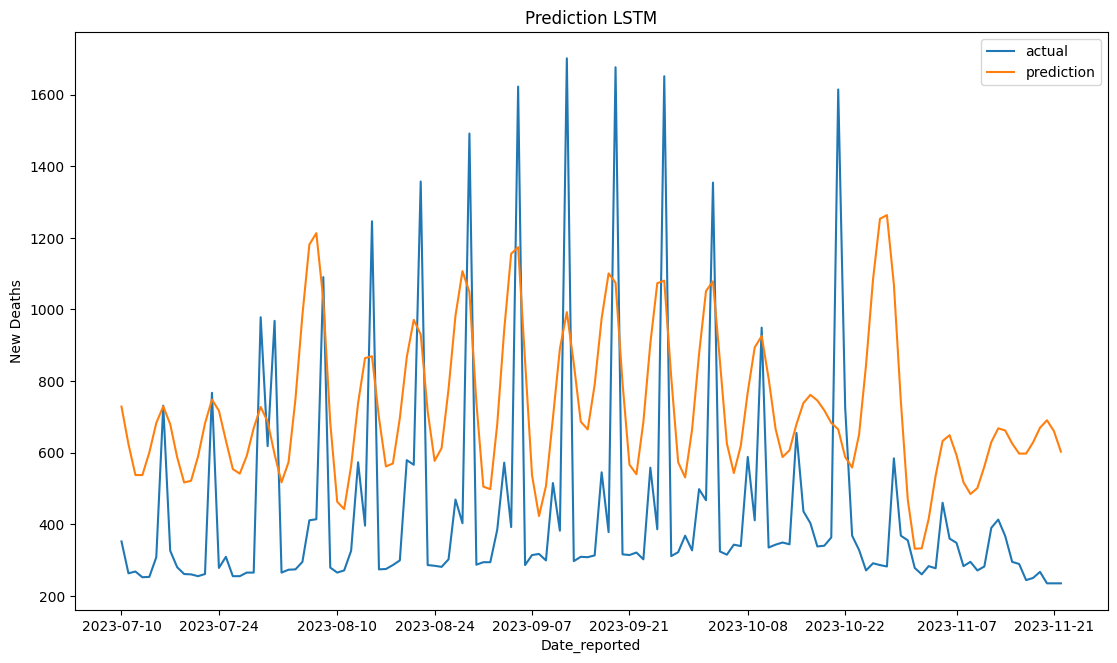

In [12]:


import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test-1, label="actual")
ax.plot(dates[-data_length:], non_zero, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [16]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test-1, unscaled_y_train-1)

Evaluation Metrics:
MSE: 164883.66
RMSE: 406.06
MAE: 360.70
MAPE: 102.20
SMAPE: 63.63
MASE: 0.21


In [20]:
store_model(regressor, "lstm")